# 【問題1】公式チュートリアルモデルを分担して実行
TensorFLowの公式チュートリアルモデルを分担して実行してください。


以下の中から1人ひとつ選び実行し、その結果を簡単に発表してください。


models/tutorials at master · tensorflow/models

In [1]:
# word2vecを採用
# ここからword2vecのドキュメントコードになります。
import io
import itertools
import numpy as np
import os
import re
import string
import tensorflow as tf
import tqdm

from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Activation, Dense, Dot, Embedding, Flatten, GlobalAveragePooling1D, Reshape
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

In [2]:
SEED = 42 
AUTOTUNE = tf.data.AUTOTUNE

In [3]:
sentence = "The wide road shimmered in the hot sun"
tokens = list(sentence.lower().split())
print(len(tokens))

8


In [4]:
# トークンから整数インデックスへのマッピングを保存するための語彙を作成

vocab, index = {}, 1 # start indexing from 1
vocab['<pad>'] = 0 # add a padding token 

for token in tokens:
    if token not in vocab: 
        vocab[token] = index
        index += 1
vocab_size = len(vocab)
print(vocab)
print(vocab_size)

{'<pad>': 0, 'the': 1, 'wide': 2, 'road': 3, 'shimmered': 4, 'in': 5, 'hot': 6, 'sun': 7}
8


In [5]:
# dictの順番を入れ替える
inverse_vocab = {index: token for token, index in vocab.items()}
print(inverse_vocab) 

{0: '<pad>', 1: 'the', 2: 'wide', 3: 'road', 4: 'shimmered', 5: 'in', 6: 'hot', 7: 'sun'}


In [6]:
# 文章をベクトル化
example_sequence = [vocab[word] for word in tokens]
print(example_sequence)

[1, 2, 3, 4, 5, 1, 6, 7]


In [7]:
# スキップグラムを生成する
# Word2Vecのデータ準備を簡素化する便利な関数を提供します。
# スキップぐらむは全てのベクトルの組み合わせを出力している

window_size = 2
positive_skip_grams, _ = tf.keras.preprocessing.sequence.skipgrams(
      example_sequence, 
      vocabulary_size=vocab_size, # 文章のトータルの長さ
      window_size=window_size, # 前後のコンテキストの数
      negative_samples=0, # ネガティブサンプリングの数
    shuffle=True) # ドロップアウト
print(len(positive_skip_grams))

positive_skip_grams

26


[[1, 6],
 [2, 3],
 [5, 3],
 [6, 7],
 [3, 5],
 [4, 1],
 [2, 4],
 [1, 4],
 [6, 1],
 [1, 2],
 [1, 7],
 [3, 1],
 [4, 5],
 [5, 1],
 [7, 1],
 [3, 4],
 [5, 6],
 [4, 2],
 [1, 5],
 [3, 2],
 [2, 1],
 [7, 6],
 [5, 4],
 [4, 3],
 [6, 5],
 [1, 3]]

In [8]:
# 例(さっきの奴を表示している)
for target, context in positive_skip_grams[:5]:
    print(f"({target}, {context}): ({inverse_vocab[target]}, {inverse_vocab[context]})")

(1, 6): (the, hot)
(2, 3): (wide, road)
(5, 3): (in, road)
(6, 7): (hot, sun)
(3, 5): (road, in)


In [9]:
# スキップぐらむからtarget、contex-wordを抽出
target_word, context_word = positive_skip_grams[0]

# ネガティブサンプリングの数
num_ns = 4

context_class = tf.reshape(tf.constant(context_word, dtype="int64"), (1, 1))
negative_sampling_candidates, _, _ = tf.random.log_uniform_candidate_sampler(
    true_classes=context_class, # ポジティブクラス全体
    num_true=1, # ポジティブクラスの数？
    num_sampled=num_ns, # ネガティブサンプリングの数
    unique=True, # all the negative samples should be unique
    range_max=vocab_size, # 持ってくる特徴量の範囲
    seed=SEED, 
    name="negative_sampling" 
)
print(negative_sampling_candidates)
print([inverse_vocab[index.numpy()] for index in negative_sampling_candidates])

#tf.constant(context_word, dtype="int64")
#tf.reshape(tf.constant(context_word, dtype="int64"), (1, 1))
context_class

tf.Tensor([2 1 4 3], shape=(4,), dtype=int64)
['wide', 'the', 'shimmered', 'road']


<tf.Tensor: shape=(1, 1), dtype=int64, numpy=array([[6]])>

In [10]:
# トレーニング例
# 次元を増やす
negative_sampling_candidates = tf.expand_dims(negative_sampling_candidates, 1)

# ポジティブワードとネガティブワードを合体させる
context = tf.concat([context_class, negative_sampling_candidates], 0)

# ラベルの作成
label = tf.constant([1] + [0]*num_ns, dtype="int64") 

# 次元を潰す
target = tf.squeeze(target_word)
context = tf.squeeze(context)
label =  tf.squeeze(label)

In [11]:
# labelの確認
print(f"target_index    : {target}")
print(f"target_word     : {inverse_vocab[target_word]}")
print(f"context_indices : {context}")
print(f"context_words   : {[inverse_vocab[c.numpy()] for c in context]}")
print(f"label           : {label}")

target_index    : 1
target_word     : the
context_indices : [6 2 1 4 3]
context_words   : ['hot', 'wide', 'the', 'shimmered', 'road']
label           : [1 0 0 0 0]


In [12]:
# スキップグラムネガティブサンプリングWord2Vecモデルをトレーニングする
print(f"target  :", target)
print(f"context :", context )
print(f"label   :", label )

target  : tf.Tensor(1, shape=(), dtype=int32)
context : tf.Tensor([6 2 1 4 3], shape=(5,), dtype=int64)
label   : tf.Tensor([1 0 0 0 0], shape=(5,), dtype=int64)


In [13]:
# 単語頻度ランクベースの確率的サンプリングテーブルを生成
sampling_table = tf.keras.preprocessing.sequence.make_sampling_table(size=10)
print(sampling_table)

[0.00315225 0.00315225 0.00547597 0.00741556 0.00912817 0.01068435
 0.01212381 0.01347162 0.01474487 0.0159558 ]


In [14]:
# トレーニングデータを生成する

# スキップグラムとネガティブサンプリングのペアをシーケンスに与える
# ウィンドウズサイズは負のサンプルに基づく
def generate_training_data(sequences, window_size, num_ns, vocab_size, seed):
    targets, contexts, labels = [], [], []
    # vocab_sizeトークンのサンプリングテーブルを作成
    sampling_table = tf.keras.preprocessing.sequence.make_sampling_table(vocab_size)
    
    # データセット内のすべてのシーケンス(文)に反復
    for sequence in tqdm.tqdm(sequences):

    # シーケンス(文)の正のスキップグラムペアを生成します。.
        positive_skip_grams, _ = tf.keras.preprocessing.sequence.skipgrams(
            sequence, 
            vocabulary_size=vocab_size,
            sampling_table=sampling_table,
            window_size=window_size,
            negative_samples=0)

    # トレーニング例を作成するために、各ポジティブスキップグラムペアを反復します。 
    # 正のコンテキストワードと負のサンプル。.
        for target_word, context_word in positive_skip_grams:
            context_class = tf.expand_dims(tf.constant([context_word], dtype="int64"), 1)
            negative_sampling_candidates, _, _ = tf.random.log_uniform_candidate_sampler(
                true_classes=context_class,
                num_true=1,
                num_sampled=num_ns, 
                unique=True, 
                range_max=vocab_size, 
                seed=SEED, 
                name="negative_sampling")

      # コンテキストを作成し、ベクトルにラベルを付けます(1つのターゲットワード)
            negative_sampling_candidates = tf.expand_dims(negative_sampling_candidates, 1)

            context = tf.concat([context_class, negative_sampling_candidates], 0)
            label = tf.constant([1] + [0]*num_ns, dtype="int64")

      # トレーニングの例からグローバルリストに各要素を追加します。.
            targets.append(target_word)
            contexts.append(context)
            labels.append(label)
    return targets, contexts, labels

In [15]:
# コーパスのDL
path_to_file = tf.keras.utils.get_file('shakespeare.txt', 'https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt')

In [16]:
# コーパスの文章
with open(path_to_file) as f: 
    lines = f.read().splitlines()
for line in lines[:20]:
    print(line)

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.

All:
We know't, we know't.

First Citizen:
Let us kill him, and we'll have corn at our own price.


In [17]:
# ベクトル化のためにDatasetへ変換
text_ds = tf.data.TextLineDataset(path_to_file).filter(lambda x: tf.cast(tf.strings.length(x), bool))
text_ds

<FilterDataset shapes: (), types: tf.string>

In [18]:
# コーパスから文をベクトル化する
# カスタム標準化機能を作成して、テキストを下げます。 
# 句読点の削除
def custom_standardization(input_data):
    lowercase = tf.strings.lower(input_data)
    return tf.strings.regex_replace(lowercase,
                                  '[%s]' % re.escape(string.punctuation), '')

# サイズと単語数を順番に定義します。.
vocab_size = 4096
sequence_length = 10

# テキストベクトル化レイヤーを使用して、文字列を正規化、分割、およびマップします。
#整数、output_sequence_length lengthを設定して、すべてのサンプルを同じ長さにパッドします。.
vectorize_layer = TextVectorization(
    standardize=custom_standardization, # 正規化
    max_tokens=vocab_size, # 語彙の最大値
    output_mode='int', 
    output_sequence_length=sequence_length) # 出力する文章の長さ

In [19]:
# テキストデータセットでadaptを呼び出して、語彙を作成します。
vectorize_layer.adapt(text_ds.batch(1024))

In [20]:
# 語彙にアクセス
# 参照用に作成したボキャブラリーを保存します。.
inverse_vocab = vectorize_layer.get_vocabulary()
print(inverse_vocab[:20])

['', '[UNK]', 'the', 'and', 'to', 'i', 'of', 'you', 'my', 'a', 'that', 'in', 'is', 'not', 'for', 'with', 'me', 'it', 'be', 'your']


In [21]:
# ベクトル生成
def vectorize_text(text):
    text = tf.expand_dims(text, -1)
    return tf.squeeze(vectorize_layer(text))

# text_dsでデータを修正します。.
text_vector_ds = text_ds.batch(1024).prefetch(AUTOTUNE).map(vectorize_layer).unbatch()

In [22]:
# シーケンスの所得
sequences = list(text_vector_ds.as_numpy_iterator())
print(len(sequences))
sequences

32777


[array([ 89, 270,   0,   0,   0,   0,   0,   0,   0,   0]),
 array([138,  36, 982, 144, 673, 125,  16, 106,   0,   0]),
 array([34,  0,  0,  0,  0,  0,  0,  0,  0,  0]),
 array([106, 106,   0,   0,   0,   0,   0,   0,   0,   0]),
 array([ 89, 270,   0,   0,   0,   0,   0,   0,   0,   0]),
 array([   7,   41,   34, 1286,  344,    4,  200,   64,    4, 3690]),
 array([34,  0,  0,  0,  0,  0,  0,  0,  0,  0]),
 array([1286, 1286,    0,    0,    0,    0,    0,    0,    0,    0]),
 array([ 89, 270,   0,   0,   0,   0,   0,   0,   0,   0]),
 array([  89,    7,   93, 1187,  225,   12, 2442,  592,    4,    2]),
 array([34,  0,  0,  0,  0,  0,  0,  0,  0,  0]),
 array([  36, 2655,   36, 2655,    0,    0,    0,    0,    0,    0]),
 array([ 89, 270,   0,   0,   0,   0,   0,   0,   0,   0]),
 array([  72,   79,  506,   27,    3,   56,   24, 1390,   57,   40]),
 array([644,   9,   1,   0,   0,   0,   0,   0,   0,   0]),
 array([34,  0,  0,  0,  0,  0,  0,  0,  0,  0]),
 array([  32,   54, 2863,  885

In [23]:
# 先端の確認
for seq in sequences[:5]:
    print(f"{seq} => {[inverse_vocab[i] for i in seq]}")

[ 89 270   0   0   0   0   0   0   0   0] => ['first', 'citizen', '', '', '', '', '', '', '', '']
[138  36 982 144 673 125  16 106   0   0] => ['before', 'we', 'proceed', 'any', 'further', 'hear', 'me', 'speak', '', '']
[34  0  0  0  0  0  0  0  0  0] => ['all', '', '', '', '', '', '', '', '', '']
[106 106   0   0   0   0   0   0   0   0] => ['speak', 'speak', '', '', '', '', '', '', '', '']
[ 89 270   0   0   0   0   0   0   0   0] => ['first', 'citizen', '', '', '', '', '', '', '', '']


In [24]:
# 例
targets, contexts, labels = generate_training_data(
    sequences=sequences, 
    window_size=2, 
    num_ns=4, 
    vocab_size=vocab_size, 
    seed=SEED)
print(len(targets), len(contexts), len(labels))

100%|██████████| 32777/32777 [00:06<00:00, 5089.14it/s]

64651 64651 64651


In [25]:
# バッチ処理
BATCH_SIZE = 1024
BUFFER_SIZE = 10000
dataset = tf.data.Dataset.from_tensor_slices(((targets, contexts), labels))
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)
print(dataset)

<BatchDataset shapes: (((1024,), (1024, 5, 1)), (1024, 5)), types: ((tf.int32, tf.int64), tf.int64)>


In [26]:
# パフォーマンス向上
dataset = dataset.cache().prefetch(buffer_size=AUTOTUNE)
print(dataset)

<PrefetchDataset shapes: (((1024,), (1024, 5, 1)), (1024, 5)), types: ((tf.int32, tf.int64), tf.int64)>


In [27]:
# クラス化
class Word2Vec(Model):
    def __init__(self, vocab_size, embedding_dim):
        super(Word2Vec, self).__init__()
        self.target_embedding = Embedding(vocab_size, 
                                      embedding_dim,
                                      input_length=1,
                                      name="w2v_embedding", )
        self.context_embedding = Embedding(vocab_size, 
                                       embedding_dim, 
                                       input_length=num_ns+1)
        self.dots = Dot(axes=(3,2))
        self.flatten = Flatten()

    def call(self, pair):
        target, context = pair
        we = self.target_embedding(target)
        ce = self.context_embedding(context)
        dots = self.dots([ce, we])
        return self.flatten(dots)

In [28]:
# 損失関数の定義
def custom_loss(x_logit, y_true):
      return tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=y_true)

In [29]:
# 次元を１２８で走らせる
embedding_dim = 128
word2vec = Word2Vec(vocab_size, embedding_dim)
word2vec.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [30]:
# テンソルボード
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="logs")

In [31]:
word2vec.fit(dataset, epochs=20, callbacks=[tensorboard_callback])

Epoch 1/20
63/63 [==============================] - 1s 7ms/step - loss: 1.6088 - accuracy: 0.2188
Epoch 2/20
63/63 [==============================] - 0s 5ms/step - loss: 1.5920 - accuracy: 0.5946
Epoch 3/20
63/63 [==============================] - 0s 6ms/step - loss: 1.5526 - accuracy: 0.6468
Epoch 4/20
63/63 [==============================] - 0s 6ms/step - loss: 1.4753 - accuracy: 0.5965
Epoch 5/20
63/63 [==============================] - 0s 6ms/step - loss: 1.3765 - accuracy: 0.5902
Epoch 6/20
63/63 [==============================] - 0s 6ms/step - loss: 1.2761 - accuracy: 0.6109
Epoch 7/20
63/63 [==============================] - 0s 5ms/step - loss: 1.1821 - accuracy: 0.6421
Epoch 8/20
63/63 [==============================] - 0s 5ms/step - loss: 1.0953 - accuracy: 0.6762
Epoch 9/20
63/63 [==============================] - 0s 5ms/step - loss: 1.0151 - accuracy: 0.7088
Epoch 10/20
63/63 [==============================] - 0s 6ms/step - loss: 0.9410 - accuracy: 0.7405
Epoch 11/20
63/63 [

In [33]:
# 重みの所得と語彙の提供
weights = word2vec.get_layer('w2v_embedding').get_weights()[0]
vocab = vectorize_layer.get_vocabulary()
weights

array([[ 0.01777324, -0.04818541,  0.0336642 , ..., -0.01610544,
        -0.01888617,  0.01173959],
       [-0.21491548, -0.09562506, -0.29324782, ...,  0.22355206,
         0.03199128, -0.08307762],
       [-0.04242772, -0.14221635,  0.15783072, ..., -0.09992789,
         0.06234811,  0.00075427],
       ...,
       [-0.21100168, -0.06658164, -0.01553096, ...,  0.11437622,
        -0.06671057, -0.06058596],
       [ 0.05052953, -0.26799157, -0.17670132, ..., -0.08679438,
         0.18281646,  0.17766985],
       [ 0.2778715 ,  0.0074762 ,  0.27932513, ...,  0.2141611 ,
         0.13084942, -0.26934868]], dtype=float32)

In [34]:
# 'vectors.tsv', 'metadata.tsv'をDLして分析
try:
    from google.colab import files
    files.download('vectors.tsv')
    files.download('metadata.tsv')
except Exception as e:
    pass

# 【問題3】Iris（2値分類）をKerasで学習
TensorFlowによるIrisデータセットに対する2値分類をKerasに書き換えてください。

In [35]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.utils import to_categorical
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

iris = load_iris()
X = iris.data[:100]
y = iris.target

y_reduce = y[:100]
y_reduce=  y_reduce.reshape(-1,1) == np.arange(2)

In [36]:
# trainとtestに分割
X_train, X_test, y_train, y_test = train_test_split(X,y_reduce, test_size=0.2, random_state=0)
# さらにtrainとvalに分割
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=0)

In [37]:
# モデル生成
def generate_model(X):
    model = Sequential()
    model.add(Dense(128, activation='relu', input_shape=X_train.shape[1:]))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(2, activation="softmax"))
    return model

model = generate_model(X_train)

# コンパイル
def generate_compile(model):
    model.compile(loss="binary_crossentropy",
                 optimizer="RMSprop", 
                 metrics = ['accuracy'])
    return model
    
model = generate_compile(model)

# 学習とpredto評価を丸める
def learning_evaluate(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train,
         batch_size=10,
         epochs=20,
         validation_data=(X_test, y_test),
         verbose=1)
    pred = model.predict(X_test)
    scores = model.evaluate(X_test, y_test)
    return pred, scores

pred, scores = learning_evaluate(model, X_train, y_train, X_val, y_val)

Epoch 1/20
7/7 [==============================] - 1s 118ms/step - loss: 0.6837 - accuracy: 0.5311 - val_loss: 0.5126 - val_accuracy: 1.0000
Epoch 2/20
7/7 [==============================] - 0s 7ms/step - loss: 0.4413 - accuracy: 0.8803 - val_loss: 0.3451 - val_accuracy: 1.0000
Epoch 3/20
7/7 [==============================] - 0s 7ms/step - loss: 0.2828 - accuracy: 1.0000 - val_loss: 0.2136 - val_accuracy: 1.0000
Epoch 4/20
7/7 [==============================] - 0s 8ms/step - loss: 0.2001 - accuracy: 1.0000 - val_loss: 0.1466 - val_accuracy: 1.0000
Epoch 5/20
7/7 [==============================] - 0s 8ms/step - loss: 0.1144 - accuracy: 1.0000 - val_loss: 0.0612 - val_accuracy: 1.0000
Epoch 6/20
7/7 [==============================] - 0s 8ms/step - loss: 0.0447 - accuracy: 1.0000 - val_loss: 0.0270 - val_accuracy: 1.0000
Epoch 7/20
7/7 [==============================] - 0s 7ms/step - loss: 0.0245 - accuracy: 1.0000 - val_loss: 0.0135 - val_accuracy: 1.0000
Epoch 8/20
7/7 [================

In [38]:
print(pred)
print("-"*50)
print(scores[0]) # loss
print(scores[1]) # accuracy

[[1.0000000e+00 3.6623393e-10]
 [1.0000000e+00 7.7537932e-10]
 [5.6286173e-14 1.0000000e+00]
 [2.5883149e-09 1.0000000e+00]
 [2.2040438e-13 1.0000000e+00]
 [1.0000000e+00 1.9002067e-10]
 [1.3381340e-13 1.0000000e+00]
 [7.0104950e-12 1.0000000e+00]
 [1.0000000e+00 3.5319244e-11]
 [2.9707366e-15 1.0000000e+00]
 [1.0000000e+00 1.7477234e-10]
 [1.0000000e+00 3.6578712e-10]
 [1.0000000e+00 5.3483880e-09]
 [1.0000000e+00 4.5502629e-10]
 [1.0000000e+00 1.0737372e-09]
 [1.0000000e+00 5.1329468e-10]]
--------------------------------------------------
1.991049066418782e-05
1.0


# 【問題4】Iris（多値分類）をKerasで学習
TensorFlowによるIrisデータセットに対する3値分類をKerasに書き換えてください。

In [39]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split


iris = load_iris()
X = iris.data
y = iris.target

y_hot = to_categorical(y)

In [40]:
# trainとtestに分割
X_train, X_test, y_train, y_test = train_test_split(X,y_hot, test_size=0.2, random_state=0)
# さらにtrainとvalに分割
X_train2, X_val2, y_train2, y_val2 = train_test_split(X_train, y_train, test_size=0.2, random_state=0)
X_train2.shape, y_train2.shape, X_val2.shape

((96, 4), (96, 3), (24, 4))

In [41]:
# 情報を１度リセット
tf.keras.backend.clear_session()

In [42]:
# モデル生成
def generate_model2(X):
    model = Sequential()
    model.add(Dense(128, activation='relu', input_shape=X.shape[1:]))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(3, activation='softmax'))
    return model

model2 = generate_model2(X_train2)
    
# コンパイル
def compile_model2(model):
    model.compile(loss='categorical_crossentropy',
                 optimizer='RMSprop',
                 metrics=['accuracy'])
    return model

model2 = compile_model2(model2)

# 学習〜予測〜評価
def learning_evaluate2(model, X_train, y_train, X_val, y_val):
    model.fit(X_train, y_train, 
             batch_size=10,
             epochs=100,
             verbose=2,
             validation_data=(X_val, y_val))
    pred = model.predict(X_val)
    score = model.evaluate(X_val, y_val)
    return pred, score

pred2, score2 = learning_evaluate2(model2, X_train2, y_train2, X_val2, y_val2)

Epoch 1/100
10/10 - 1s - loss: 0.9544 - accuracy: 0.5417 - val_loss: 0.7132 - val_accuracy: 0.6250
Epoch 2/100
10/10 - 0s - loss: 0.6427 - accuracy: 0.7292 - val_loss: 0.5590 - val_accuracy: 0.7083
Epoch 3/100
10/10 - 0s - loss: 0.5749 - accuracy: 0.6667 - val_loss: 0.4879 - val_accuracy: 0.7083
Epoch 4/100
10/10 - 0s - loss: 0.5602 - accuracy: 0.6771 - val_loss: 0.4583 - val_accuracy: 0.7917
Epoch 5/100
10/10 - 0s - loss: 0.5074 - accuracy: 0.7500 - val_loss: 0.4186 - val_accuracy: 0.9167
Epoch 6/100
10/10 - 0s - loss: 0.3870 - accuracy: 0.8333 - val_loss: 0.3852 - val_accuracy: 0.8333
Epoch 7/100
10/10 - 0s - loss: 0.3775 - accuracy: 0.8229 - val_loss: 0.3317 - val_accuracy: 0.9167
Epoch 8/100
10/10 - 0s - loss: 0.3385 - accuracy: 0.8542 - val_loss: 0.2792 - val_accuracy: 0.9167
Epoch 9/100
10/10 - 0s - loss: 0.2567 - accuracy: 0.8854 - val_loss: 0.4581 - val_accuracy: 0.7083
Epoch 10/100
10/10 - 0s - loss: 0.2138 - accuracy: 0.9167 - val_loss: 0.4341 - val_accuracy: 0.7500
Epoch 11/

10/10 - 0s - loss: 0.0439 - accuracy: 0.9896 - val_loss: 0.4015 - val_accuracy: 0.9167
Epoch 84/100
10/10 - 0s - loss: 0.0515 - accuracy: 0.9792 - val_loss: 0.2780 - val_accuracy: 0.9167
Epoch 85/100
10/10 - 0s - loss: 0.1225 - accuracy: 0.9583 - val_loss: 0.2626 - val_accuracy: 0.9167
Epoch 86/100
10/10 - 0s - loss: 0.0465 - accuracy: 0.9792 - val_loss: 0.4589 - val_accuracy: 0.9167
Epoch 87/100
10/10 - 0s - loss: 0.1176 - accuracy: 0.9583 - val_loss: 0.2826 - val_accuracy: 0.9167
Epoch 88/100
10/10 - 0s - loss: 0.0450 - accuracy: 0.9896 - val_loss: 0.4389 - val_accuracy: 0.9167
Epoch 89/100
10/10 - 0s - loss: 0.0790 - accuracy: 0.9688 - val_loss: 0.3089 - val_accuracy: 0.9167
Epoch 90/100
10/10 - 0s - loss: 0.0958 - accuracy: 0.9688 - val_loss: 0.2364 - val_accuracy: 0.9167
Epoch 91/100
10/10 - 0s - loss: 0.0492 - accuracy: 0.9896 - val_loss: 0.2379 - val_accuracy: 0.9583
Epoch 92/100
10/10 - 0s - loss: 0.1322 - accuracy: 0.9583 - val_loss: 0.2358 - val_accuracy: 0.8333
Epoch 93/100


In [43]:
print(pred2)
print("-"*50)
print(score2[0]) # loss
print(score2[1]) # accuracy

[[1.00000000e+00 2.59248640e-08 5.85907910e-18]
 [3.00478791e-06 2.23383051e-03 9.97763157e-01]
 [1.00000000e+00 1.26122810e-08 7.18309995e-19]
 [1.28562606e-05 9.99644279e-01 3.42887710e-04]
 [1.21932144e-05 9.99757349e-01 2.30536680e-04]
 [3.69617956e-05 9.98410344e-01 1.55259727e-03]
 [5.68936957e-05 1.16195651e-02 9.88323569e-01]
 [6.75769707e-06 3.37338005e-03 9.96619821e-01]
 [9.99999881e-01 1.01693225e-07 5.87084955e-17]
 [1.46327855e-03 1.94461793e-01 8.04074883e-01]
 [7.05397906e-05 9.97999489e-01 1.92995754e-03]
 [2.73101762e-07 5.55366219e-04 9.99444306e-01]
 [1.00000000e+00 5.88556137e-09 1.41568317e-19]
 [2.85381816e-06 2.01826287e-03 9.97978866e-01]
 [1.00000000e+00 4.32552909e-08 1.24544019e-17]
 [1.69192461e-07 4.27974126e-04 9.99571860e-01]
 [2.73991700e-05 9.99063313e-01 9.09348193e-04]
 [1.00000000e+00 1.09063925e-10 7.04530791e-23]
 [2.47192476e-03 3.97610039e-01 5.99918127e-01]
 [1.00000000e+00 5.60887266e-08 1.21988444e-17]
 [1.00000000e+00 5.35425961e-08 1.058779

# 【問題5】House PricesをKerasで学習
TensorFlowによるHouse Pricesデータセットに対する回帰をKerasに書き換えてください。

In [49]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

dir_path = '/Users/yuki.tatsuoka/Downloads/house-prices-advanced-regression-techniques/'
house_price_train = pd.read_csv(dir_path + 'train.csv')
house_price_test = pd.read_csv(dir_path + 'test.csv')
pd.set_option('display.max_rows', 300)


y = house_price_train['SalePrice']
X = house_price_train.drop(['SalePrice'], axis=1)

# object型の変換と欠損値を埋めることが必須条件
X = X.fillna(0)
X = pd.get_dummies(X)

In [50]:
X.isnull().sum().sum()

0

In [51]:
# 対数と標準化
y_log = np.log(y)

In [52]:
# trainとtestに分割
X_train, X_test, y_train, y_test = train_test_split(X,y_log, test_size=0.2, random_state=0)
# さらにtrainとvalに分割
X_train3, X_val3, y_train3, y_val3 = train_test_split(X_train, y_train, test_size=0.2, random_state=0)
X_train3.shape, y_train3.shape, X_val3.shape

((934, 305), (934,), (234, 305))

In [53]:
# 情報を１度リセット
tf.keras.backend.clear_session()

# モデル生成
def generate_model3(X):
    model = Sequential()
    model.add(Dense(128, activation='relu', input_shape=X.shape[1:]))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    return model

model3 = generate_model3(X_train3)
    
# コンパイル
def compile_model3(model):
    model.compile(loss='mean_squared_error',
                 optimizer='RMSprop')
    return model

model3 = compile_model3(model3)

# 学習〜予測〜評価
def learning_evaluate3(model, X_train, y_train, X_val, y_val):
    model.fit(X_train, y_train, 
             batch_size=10,
             epochs=50,
             verbose=2,
             validation_data=(X_val, y_val))
    pred = model.predict(X_val)
    score = model.evaluate(X_val, y_val)
    return pred, score

pred3, score3 = learning_evaluate3(model3, X_train3, y_train3, X_val3, y_val3)

Epoch 1/50
94/94 - 1s - loss: 2884.2520 - val_loss: 28.3369
Epoch 2/50
94/94 - 0s - loss: 213.0573 - val_loss: 132.5678
Epoch 3/50
94/94 - 0s - loss: 95.8974 - val_loss: 132.4888
Epoch 4/50
94/94 - 0s - loss: 63.3652 - val_loss: 11.1965
Epoch 5/50
94/94 - 0s - loss: 123.8372 - val_loss: 7.0566
Epoch 6/50
94/94 - 0s - loss: 20.1396 - val_loss: 3.1489
Epoch 7/50
94/94 - 0s - loss: 17.1559 - val_loss: 1.8038
Epoch 8/50
94/94 - 0s - loss: 15.6823 - val_loss: 1.1308
Epoch 9/50
94/94 - 0s - loss: 12.5865 - val_loss: 0.9796
Epoch 10/50
94/94 - 0s - loss: 8.5612 - val_loss: 0.5217
Epoch 11/50
94/94 - 0s - loss: 82.2444 - val_loss: 2.9310
Epoch 12/50
94/94 - 0s - loss: 7.5305 - val_loss: 3.2436
Epoch 13/50
94/94 - 0s - loss: 8.3955 - val_loss: 0.6302
Epoch 14/50
94/94 - 0s - loss: 6.0256 - val_loss: 0.2879
Epoch 15/50
94/94 - 0s - loss: 18.6386 - val_loss: 7.2047
Epoch 16/50
94/94 - 0s - loss: 5.5022 - val_loss: 0.5529
Epoch 17/50
94/94 - 0s - loss: 4.7134 - val_loss: 2.4725
Epoch 18/50
94/94 -

In [54]:
print(pred3)
print("-"*50)
print(score3) # loss

[[10.294497 ]
 [ 9.931913 ]
 [10.59292  ]
 [10.753576 ]
 [10.421829 ]
 [10.369633 ]
 [10.226046 ]
 [10.887756 ]
 [10.697958 ]
 [10.453474 ]
 [10.898138 ]
 [10.759673 ]
 [10.377462 ]
 [10.611592 ]
 [10.519287 ]
 [10.429358 ]
 [10.344372 ]
 [10.326325 ]
 [ 9.945929 ]
 [10.182088 ]
 [10.276302 ]
 [10.420287 ]
 [10.381678 ]
 [10.358595 ]
 [ 9.964156 ]
 [10.403975 ]
 [10.263159 ]
 [10.661478 ]
 [10.612439 ]
 [10.386406 ]
 [10.291065 ]
 [10.91334  ]
 [10.690382 ]
 [10.227119 ]
 [10.629871 ]
 [10.261059 ]
 [10.371103 ]
 [10.350756 ]
 [10.341781 ]
 [10.378433 ]
 [10.422536 ]
 [10.35232  ]
 [10.237168 ]
 [10.58633  ]
 [10.783978 ]
 [10.755438 ]
 [10.353922 ]
 [10.592376 ]
 [10.238395 ]
 [10.540099 ]
 [10.346765 ]
 [10.166983 ]
 [10.610328 ]
 [11.079455 ]
 [10.270264 ]
 [11.055691 ]
 [11.364849 ]
 [10.425469 ]
 [10.301411 ]
 [10.687977 ]
 [11.250284 ]
 [10.783877 ]
 [10.2330475]
 [10.9694395]
 [10.246107 ]
 [10.926512 ]
 [10.345179 ]
 [10.415503 ]
 [10.984261 ]
 [ 9.980065 ]
 [10.155104 ]
 [10.0

# 【問題6】MNISTをKerasで学習
TensorFlowによるMNISTデータセットによる画像の多値分類をKerasに書き換えてください。

In [55]:
from tensorflow.keras.datasets import mnist

(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train.shape

(60000, 28, 28)

In [56]:
# さらにtrainとvalに分割
X_train4, X_val4, y_train4, y_val4 = train_test_split(X_train, y_train, test_size=0.2, random_state=0)
X_train4.shape, y_train4.shape, X_val4.shape

# ワンホット
y_train4 = to_categorical(y_train4)
y_val4 = to_categorical(y_val4)

# チャネルの追加
X_train4 = X_train4.reshape(-1,28,28,1)
X_val4 = X_val4.reshape(-1,28,28,1)

X_train4.shape, y_train4.shape, X_val4.shape

((48000, 28, 28, 1), (48000, 10), (12000, 28, 28, 1))

In [57]:
# モデル生成
def generate_model4(X):
    model = Sequential()
    Conv2D, MaxPool2D
    
    model.add(Conv2D(32, kernel_size=(3,3), padding='same', input_shape=X.shape[1:]))
    model.add(Activation('relu'))
    model.add(MaxPool2D(pool_size=(2, 2), padding='same'))
    model.add(Conv2D(64, kernel_size=(3,3), padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPool2D(pool_size=(2, 2), padding='same'))
    model.add(Dropout(0.25))
    model.add(Flatten())
    
    model.add(Dense(128, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(10, activation='softmax'))
    return model

model4 = generate_model4(X_train4)
    
# コンパイル
def compile_model4(model):
    model.compile(loss='categorical_crossentropy',
                 optimizer='RMSprop',
                 metrics=['accuracy'])
    return model

model4 = compile_model4(model4)

# 学習〜予測〜評価
def learning_evaluate4(model, X_train, y_train, X_val, y_val):
    history = model.fit(X_train, y_train, 
             batch_size=200,
             epochs=10,
             verbose=2,
             validation_data=(X_val, y_val))
    pred = model.predict(X_val)
    score = model.evaluate(X_val, y_val)
    return history, pred, score

history, pred4, score4 = learning_evaluate4(model4, X_train4, y_train4, X_val4, y_val4)

Epoch 1/10
240/240 - 20s - loss: 0.9495 - accuracy: 0.7944 - val_loss: 0.1000 - val_accuracy: 0.9731
Epoch 2/10
240/240 - 43s - loss: 0.1395 - accuracy: 0.9641 - val_loss: 0.0662 - val_accuracy: 0.9822
Epoch 3/10
240/240 - 35s - loss: 0.0910 - accuracy: 0.9770 - val_loss: 0.0938 - val_accuracy: 0.9761
Epoch 4/10
240/240 - 28s - loss: 0.0731 - accuracy: 0.9810 - val_loss: 0.0490 - val_accuracy: 0.9880
Epoch 5/10
240/240 - 25s - loss: 0.0591 - accuracy: 0.9847 - val_loss: 0.0551 - val_accuracy: 0.9881
Epoch 6/10
240/240 - 26s - loss: 0.0508 - accuracy: 0.9873 - val_loss: 0.0542 - val_accuracy: 0.9872
Epoch 7/10
240/240 - 19s - loss: 0.0412 - accuracy: 0.9893 - val_loss: 0.0545 - val_accuracy: 0.9876
Epoch 8/10
240/240 - 27s - loss: 0.0399 - accuracy: 0.9899 - val_loss: 0.0504 - val_accuracy: 0.9892
Epoch 9/10
240/240 - 23s - loss: 0.0358 - accuracy: 0.9912 - val_loss: 0.0511 - val_accuracy: 0.9895
Epoch 10/10
240/240 - 25s - loss: 0.0330 - accuracy: 0.9918 - val_loss: 0.0475 - val_accura

In [58]:
# 予測数値と損失と評価の確認
print(pred4)
print("-"*50)
print(score4[0]) # loss
print(score4[1]) # accuracy

[[1.1871069e-17 1.5434344e-29 3.5443342e-15 ... 9.9585237e-20
  5.8374699e-15 2.2344327e-19]
 [2.1665350e-10 1.1452689e-22 1.9113899e-23 ... 2.0906006e-19
  4.4891686e-14 1.1669907e-19]
 [1.5132775e-08 3.7388636e-17 7.3652129e-17 ... 3.0698825e-15
  3.3357520e-12 3.4938464e-15]
 ...
 [4.9897803e-14 1.0184955e-21 6.7238731e-19 ... 6.0966293e-10
  6.1884601e-13 4.3386274e-11]
 [7.2186239e-09 9.9999964e-01 7.1533862e-08 ... 3.1197320e-10
  1.9082248e-07 4.8933384e-08]
 [9.1876076e-11 5.1872006e-23 1.3034000e-23 ... 2.5179667e-20
  1.6703527e-15 2.7750410e-20]]
--------------------------------------------------
0.04750441014766693
0.9892500042915344


In [59]:
# 重みの所得
model4.get_weights()

[array([[[[ 0.0507528 , -0.04234311,  0.05209729, -0.10917363,
           -0.01865141, -0.07068711,  0.02367098,  0.04977283,
           -0.11645245,  0.03383624, -0.03970184,  0.0464965 ,
            0.00333867, -0.00424803,  0.01026364,  0.03834292,
           -0.07254401, -0.0994952 , -0.01410242, -0.13971601,
           -0.06558211, -0.06763384,  0.01114204,  0.02722306,
           -0.06036509, -0.12916164, -0.08977292, -0.03491903,
           -0.20599626, -0.01597884, -0.0814885 , -0.11269344]],
 
         [[ 0.04543024,  0.08034417, -0.05681614,  0.0529106 ,
            0.04466083, -0.10623419,  0.0626259 ,  0.0088357 ,
           -0.04772372, -0.12689574, -0.04812716,  0.03832018,
           -0.1634425 ,  0.08152449, -0.0209031 , -0.02923365,
            0.08367016,  0.08368703, -0.1536215 ,  0.07478874,
            0.05923582,  0.00072663, -0.12934716, -0.06011619,
           -0.09711666,  0.05176982, -0.01039968,  0.0574679 ,
            0.04096891,  0.05059408,  0.1304165 ,  

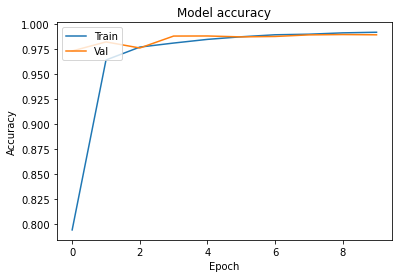

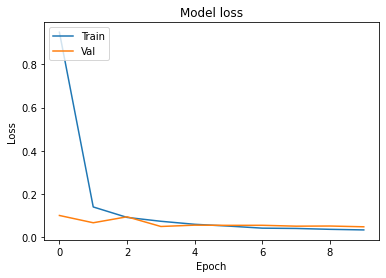

In [60]:
import matplotlib.pyplot as plt

# accracy可視化
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

#loss可視化
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

#　valが最初から高いので過学習気味か？？